## Imports & Setup

In [1]:
import pathlib
import curie as ci
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.special import factorial
from uncertainties.umath import exp as uexp
from uncertainties import ufloat, correlated_values, unumpy

%matplotlib inline
matplotlib.rcParams.update({
                            'font.size': 14,
                            'axes.labelsize': 13,
                            'axes.titlesize': 16, 
                            'xtick.labelsize': 12, 
                            'ytick.labelsize': 12, 
                            'legend.fontsize': 10,
                            'figure.titlesize': 16,
                            'figure.figsize': (14, 8)
                           })

     

class Path(pathlib.Path):
    '''Wrapper for pathlib.Path to ensure string representation is used in Spectrum class.'''
    def endswith(self, suffix):
        return str(self).endswith(suffix)
    
    def split(self, sep=None):
        return str(self).split(sep)
    
    def __add__(self, other: str):
        return Path(str(self) + other)
    
    def __radd__(self, other: str):
        return Path(other + str(self))
    
root_path = Path.cwd().parent 

spec_filename  = root_path / 'spectra'
spec_calib_path = spec_filename / 'calibration'
spec_exp_path   = spec_filename / 'experiment'
spec_test_path  = spec_filename / 'test'
fig_path = root_path / 'figs'

## Calibration

In [2]:
calib_path_Cs = spec_calib_path / 'AA110625_Cs137.Spe'
calib_path_Ba = spec_calib_path / 'AB110625_Ba133.Spe'
calib_path_Eu = spec_calib_path / 'AC110625_Eu152.Spe'

# Extract the spectrums for calibration
cb = ci.Calibration()
sp_Cs137 = ci.Spectrum(calib_path_Cs)
sp_Ba133 = ci.Spectrum(calib_path_Ba)
sp_Eu152 = ci.Spectrum(calib_path_Eu)

# Assign isotopes to the spectrums. Our calibration samples are 100% Cs137, Ba133, and Eu152
# Note: Isotope names must be uppercase
sp_Cs137.isotopes = ['137CS']
sp_Ba133.isotopes = ['133BA']
sp_Eu152.isotopes = ['152EU']


def Ci_to_Bq(Ci):
    """Convert Curie to Becquerel."""
    return Ci * 3.7e10  # 1 Ci = 3.7e10 Bq

# Add information about the sources
# Note: Isotope names must be uppercase
sources = [
    {'isotope': '133BA',
     'A0': Ci_to_Bq(10.78*1e-6),
     'ref_date': '10/01/1988 12:00:00'},
    {'isotope': '137CS', 
     'A0': Ci_to_Bq(11.46*1e-6), 
     'ref_date': '02/01/1979 12:00:00'},
    {'isotope': '152EU',
     'A0': 150*1e3,
     'ref_date': '01/01/2002 12:00:00'}
]

Reading Spectrum /home/oskar/repos/summer_project/spectra/calibration/AA110625_Cs137.Spe
Reading Spectrum /home/oskar/repos/summer_project/spectra/calibration/AB110625_Ba133.Spe
Reading Spectrum /home/oskar/repos/summer_project/spectra/calibration/AC110625_Eu152.Spe


In [3]:
sources = pd.DataFrame(sources)
cb.calibrate([sp_Ba133, sp_Cs137, sp_Eu152], sources=sources)
cb.saveas(root_path / 'calibration.json')

### Plotting Efficiency Curve

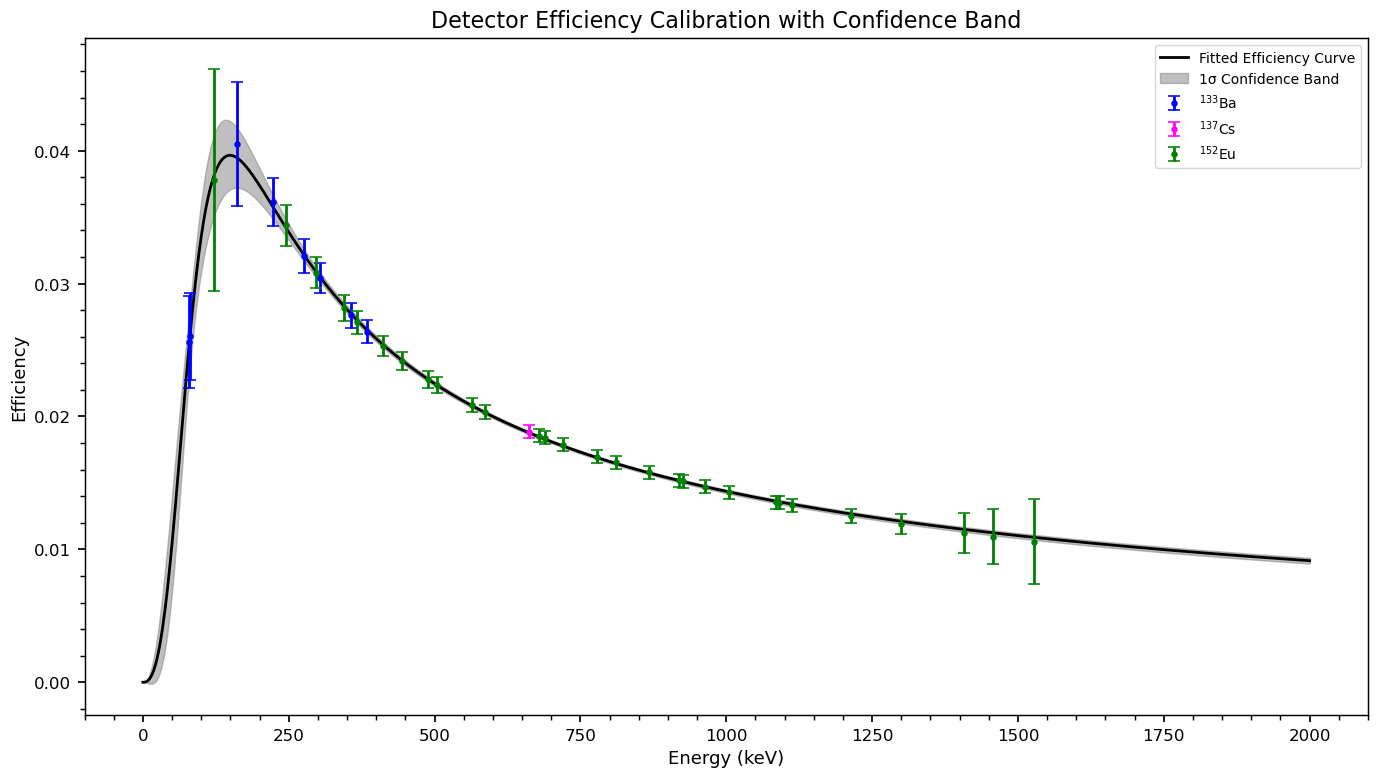

In [4]:
isotope_energy_set = []
efficiencies = []
unc_efficiencies = []
isotopes = []

for sp in [sp_Ba133, sp_Cs137, sp_Eu152]:
    for energy, ε, unc_ε, iso in zip(sp.peaks['energy'], sp.peaks['efficiency'], sp.peaks['unc_efficiency'], sp.peaks['isotope']):
        isotope_energy_set.append(energy)
        efficiencies.append(ε)
        unc_efficiencies.append(unc_ε)
        isotopes.append(iso)

isotope_energy_set = np.array(isotope_energy_set)
efficiencies = np.array(efficiencies)
unc_efficiencies = np.array(unc_efficiencies)
        
def efficiency_curve(E, a, b, c, d):
    return a * E**b/(c + E**d)

# Fit the efficiency data to the model
p0 = [20, 1, 5e+4, 2]  # Initial guess for parameters from testing parameters manually
efficiency_curve_params, cov = curve_fit(efficiency_curve, isotope_energy_set, efficiencies, p0=[20, 1, 5e+4, 2], sigma=unc_efficiencies, absolute_sigma=True)

energy_range = np.linspace(0, 2000, 1000)
fitted_efficiency = efficiency_curve(energy_range, *efficiency_curve_params)

# Create correlated ufloat objects for the fitted parameters
u_efficiency_curve_params = correlated_values(efficiency_curve_params, cov)
# Calculate the fitted efficiency with uncertainties
u_fitted_efficiency = efficiency_curve(energy_range, *u_efficiency_curve_params)
# Extract nominal values and standard deviations
fitted_efficiency_nom = unumpy.nominal_values(u_fitted_efficiency)
fitted_efficiency_std = unumpy.std_devs(u_fitted_efficiency)



# Plotting the confidence band
plt.plot(energy_range, fitted_efficiency_nom, color='black', label='Fitted Efficiency Curve')
plt.fill_between(energy_range, 
                 fitted_efficiency_nom - fitted_efficiency_std, 
                 fitted_efficiency_nom + fitted_efficiency_std, 
                 color='gray', alpha=0.5, label='1σ Confidence Band')

plt.errorbar(sp_Ba133.peaks['energy'], sp_Ba133.peaks['efficiency'], yerr=sp_Ba133.peaks['unc_efficiency'], fmt='o', label=r'$^{133}$Ba', color='blue')
plt.errorbar(sp_Cs137.peaks['energy'], sp_Cs137.peaks['efficiency'], yerr=sp_Cs137.peaks['unc_efficiency'], fmt='o', label=r'$^{137}$Cs', color='magenta')
plt.errorbar(sp_Eu152.peaks['energy'], sp_Eu152.peaks['efficiency'], yerr=sp_Eu152.peaks['unc_efficiency'], fmt='o', label=r'$^{152}$Eu', color='green')

plt.xlabel('Energy (keV)')
plt.ylabel('Efficiency')
plt.title('Detector Efficiency Calibration with Confidence Band')
plt.legend()
plt.show()

## Testing

<Figure size 1400x800 with 0 Axes>

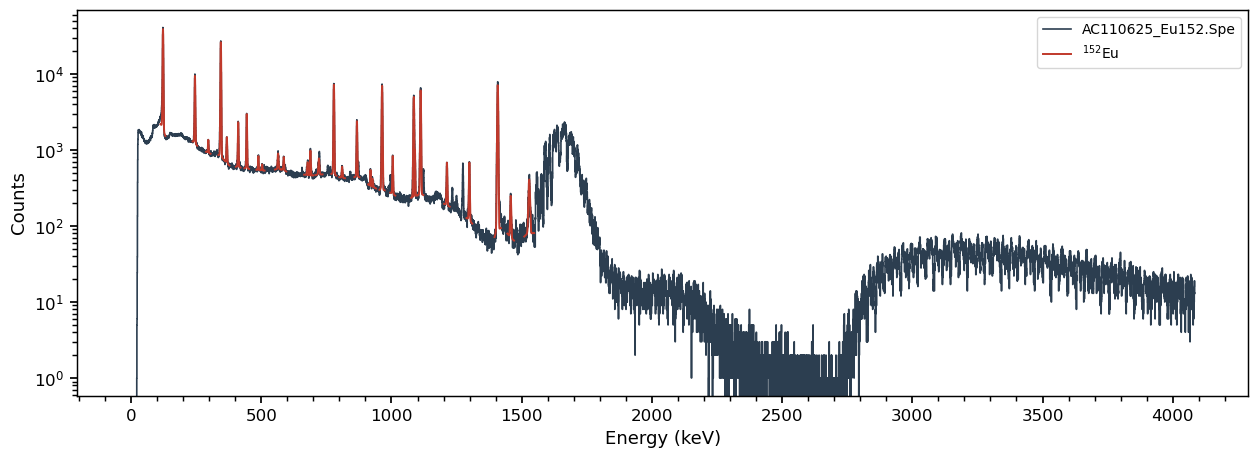

In [5]:
sp_Eu152.cb = cb
plt.clf()
fig, ax = sp_Eu152.plot(return_plot=True)

In [6]:
# sp_Eu152.sumamrize()
a = set()
a.update(zip(sp_Ba133.peaks['energy'].array, sp_Ba133.peaks['isotope'].array))
print(a)
print(*sp_Ba133.peaks['energy'].array)

{(276.3989, '133BA'), (383.8485, '133BA'), (302.8508, '133BA'), (160.612, '133BA'), (356.0129, '133BA'), (80.9979, '133BA'), (79.6142, '133BA'), (223.2368, '133BA')}
79.6142 80.9979 160.612 223.2368 276.3989 302.8508 356.0129 383.8485


In [7]:
def energy_data(sp: ci.Spectrum) -> list[tuple[float, dict]]:
    """Extract energy from Spectrum object""" 
    energies = []
    for E, iso, N_c, unc_N_c, I, unc_I, ε, unc_ε, λ, unc_λ, rt, lt in zip(sp.peaks['energy'].array, sp.peaks['isotope'],
                                                                     sp.peaks['counts'].array, sp.peaks['unc_counts'].array, 
                                                                     sp.peaks['intensity'].array, sp.peaks['unc_intensity'].array, 
                                                                     sp.peaks['efficiency'].array, sp.peaks['unc_efficiency'].array, sp.peaks['decay_rate'].array, sp.peaks['unc_decay_rate'].array, 
                                                                     sp.peaks['real_time'].array, sp.peaks['live_time'].array
                                                          ):
        data = {
            'isotope': iso,
            'counts': N_c,
            'unc_counts': unc_N_c,
            'intensity': I,
            'unc_intensity': unc_I,
            'efficiency': ε,
            'unc_efficiency': unc_ε,
            # 'decay_rate': λ,
            # 'unc_decay_rate': unc_λ,
            'real_time': rt,
            'live_time': lt    
        }
        data['decay_rate'] = ci.Isotope(iso).decay_const()
        
        
        energies.append((E, data))
        
    return energies


def Activity(t, A0, λ):
    return A0*np.exp(-λ*t)

In [8]:
job_name = 'job1_Ag4_1min_real10_loop6_'
spec_filename = spec_exp_path / (job_name + '001.Spe')

sp = ci.Spectrum(spec_filename)
# Note: Can use the calibration object created above, but we already saved it to a file
# sp.cb = cb
sp.cb = ci.Calibration(root_path / 'calibration.json')
sp.isotopes = ['108AG', '110AG']

print('Energies and counts:')
isotope_energy_set = energy_data(sp)
print(isotope_energy_set)

# sp.plot(return_plot=True)

Reading Spectrum /home/oskar/repos/summer_project/spectra/experiment/job1_Ag4_1min_real10_loop6_001.Spe
Energies and counts:
[(433.96, {'isotope': '108AG', 'counts': 26.66623270881777, 'unc_counts': 5.846834261363426, 'intensity': 0.005, 'unc_intensity': 0.00025, 'efficiency': 0.02450041949967394, 'unc_efficiency': 0.0007184038689308501, 'real_time': 10.0, 'live_time': 9.0, 'decay_rate': 0.004849896309543418}), (632.98, {'isotope': '108AG', 'counts': 31.873431083603947, 'unc_counts': 5.528830490963141, 'intensity': 0.0176, 'unc_intensity': 0.001, 'efficiency': 0.019405772268799335, 'unc_efficiency': 0.0005125029458983969, 'real_time': 10.0, 'live_time': 9.0, 'decay_rate': 0.004849896309543418}), (657.5, {'isotope': '110AG', 'counts': 320.5436318783905, 'unc_counts': 14.970488234371642, 'intensity': 0.045, 'unc_intensity': 0.0022500000000000003, 'efficiency': 0.01894346257453844, 'unc_efficiency': 0.0005046895008075428, 'real_time': 10.0, 'live_time': 9.0, 'decay_rate': 0.02817671465690

Reading Spectrum /home/oskar/repos/summer_project/spectra/experiment/job1_Ag4_1min_real10_loop6_000.Spe
Reading Spectrum /home/oskar/repos/summer_project/spectra/experiment/job1_Ag4_1min_real10_loop6_001.Spe


/home/oskar/miniconda3/envs/myenv/lib/python3.12/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")
/home/oskar/miniconda3/envs/myenv/lib/python3.12/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


Reading Spectrum /home/oskar/repos/summer_project/spectra/experiment/job1_Ag4_1min_real10_loop6_002.Spe
Reading Spectrum /home/oskar/repos/summer_project/spectra/experiment/job1_Ag4_1min_real10_loop6_003.Spe


/home/oskar/miniconda3/envs/myenv/lib/python3.12/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")
/home/oskar/miniconda3/envs/myenv/lib/python3.12/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


Reading Spectrum /home/oskar/repos/summer_project/spectra/experiment/job1_Ag4_1min_real10_loop6_004.Spe
Reading Spectrum /home/oskar/repos/summer_project/spectra/experiment/job1_Ag4_1min_real10_loop6_005.Spe


/home/oskar/miniconda3/envs/myenv/lib/python3.12/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")
/home/oskar/miniconda3/envs/myenv/lib/python3.12/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


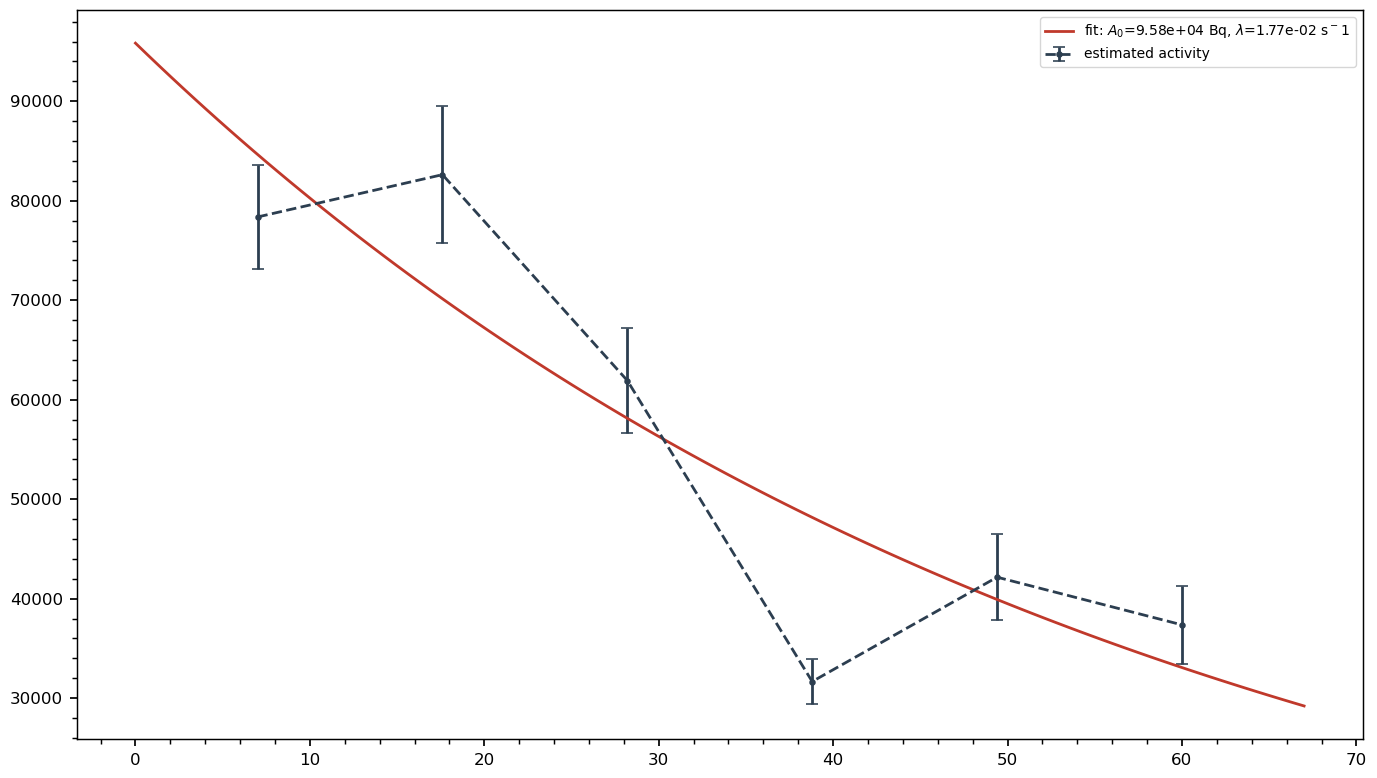

In [9]:
job_name = 'job1_Ag4_1min_real10_loop6_'
activities = []
uncertancies = []

n_loops = 6
for i in range(n_loops):
    spec_filename = spec_exp_path / (job_name + f'{i:03d}.Spe')
    sp5 = ci.Spectrum(spec_filename)
    sp5.cb = ci.Calibration(root_path / 'calibration.json')
    sp5.isotopes = ['108AG', '110AG']
    
    A = ufloat(0, 0)
    for energy, data in energy_data(sp5):
        isotope = data['isotope']
        N_c     = data['counts']
        unc_N_c = data['unc_counts']
        λ       = data['decay_rate']
        I_γ     = data['intensity']
        unc_I_γ = data['unc_intensity']   
        ε       = data['efficiency']
        unc_ε   = data['unc_efficiency']
        Δt_c    = data['live_time']
        Δt_r    = data['real_time']
        
        N_c_u = ufloat(N_c, unc_N_c)
        I_γ_u = ufloat(I_γ, unc_I_γ)
        ε_u   = ufloat(ε, unc_ε)
        
        A += (N_c_u * λ)/(ε_u*I_γ_u*(1 - uexp(-λ*Δt_c)))

     
     
    activities.append(A.nominal_value)
    uncertancies.append(A.std_dev) 
    # activities.append(A/Δt_r) ? 
plt.clf()

isotope_energy_set = energy_data(sp5)
period = data['real_time']
start = 7 # s
real_times = np.linspace(start, n_loops*period, n_loops)
actual_time = np.linspace(0, start + n_loops*period, 100)

p0 = (1000, 0.01)
efficiency_curve_params, cv = curve_fit(Activity, real_times, activities, p0=p0)
A0, λ = efficiency_curve_params

plt.clf()
plt.errorbar(real_times, activities, yerr=uncertancies, fmt='o--', label = 'estimated activity')
plt.plot(actual_time, Activity(actual_time, A0, λ), label = fr'fit: $A_0$={A0:.2e} Bq, $λ$={λ:.2e} s$^{-1}$')

plt.legend()
plt.show()

In [10]:
# TODO: 
# 1. Iterate over all epxeriment loops and plot activity. How to plot activity over a time period? Just take the average and plot in the middle of the time period? Just divide by the number of seconds and plot in the middle of the time period? Use the A(Δt_d) at eq. 4.4 in Ekeberg thesis?
# 2. Interpolate the activity to get the activity at the time of irradiation
# 3. Make into a class/function that can be reused for other jobs
# 4. Calculate cross-section

Reading Spectrum /home/oskar/repos/summer_project/spectra/experiment/job3_Ag73_3min_real40_loop3_000.Spe
Reading Spectrum /home/oskar/repos/summer_project/spectra/experiment/job3_Ag73_3min_real40_loop3_001.Spe
Reading Spectrum /home/oskar/repos/summer_project/spectra/experiment/job3_Ag73_3min_real40_loop3_002.Spe


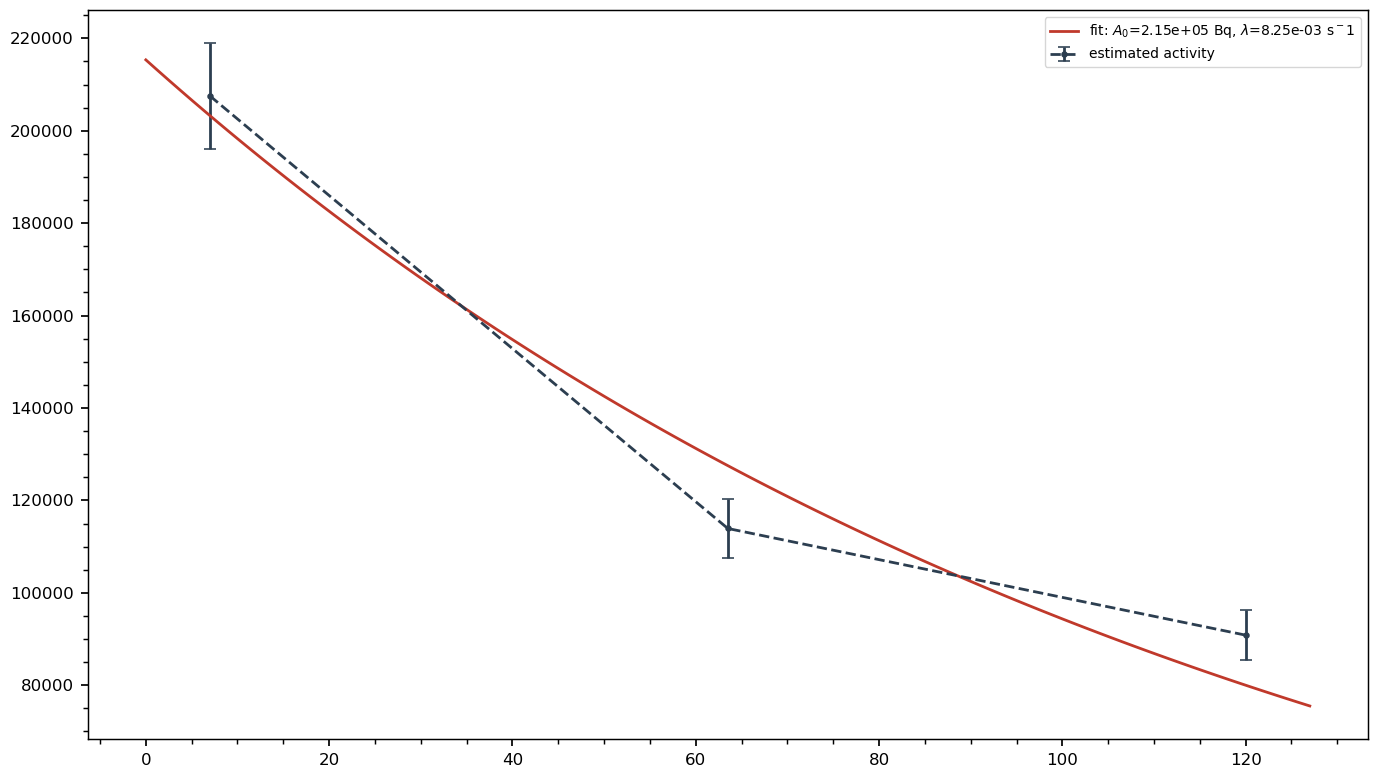

In [11]:
job_name = 'job3_Ag73_3min_real40_loop3_'
activities = []
uncertancies = []

n_loops = 3
for i in range(n_loops):
    spec_filename = spec_exp_path / (job_name + f'{i:03d}.Spe')
    sp5 = ci.Spectrum(spec_filename)
    sp5.cb = ci.Calibration(root_path / 'calibration.json')
    sp5.isotopes = ['108AG', '110AG']
    
    A = ufloat(0, 1e-16) # Small uncertainty to avoid warning
    for energy, data in energy_data(sp5):
        isotope = data['isotope']
        N_c     = data['counts']
        unc_N_c = data['unc_counts']
        λ       = data['decay_rate']
        I_γ     = data['intensity']
        unc_I_γ = data['unc_intensity']   
        ε       = data['efficiency']
        unc_ε   = data['unc_efficiency']
        Δt_c    = data['live_time']
        Δt_r    = data['real_time']
        
        N_c_u = ufloat(N_c, unc_N_c)
        I_γ_u = ufloat(I_γ, unc_I_γ)
        ε_u   = ufloat(ε, unc_ε)
        
        A += (N_c_u * λ)/(ε_u*I_γ_u*(1 - uexp(-λ*Δt_c)))

     
     
    activities.append(A.nominal_value)
    uncertancies.append(A.std_dev) 
    # activities.append(A/Δt_r) ? 
plt.clf()

isotope_energy_set = energy_data(sp5)
period = data['real_time']
start = 7 # s
real_times = np.linspace(start, n_loops*period, n_loops)
actual_time = np.linspace(0, start + n_loops*period, 100)

p0 = (1000, 0.01)
efficiency_curve_params, cv = curve_fit(Activity, real_times, activities, p0=p0)
A0, λ = efficiency_curve_params

plt.clf()
plt.errorbar(real_times, activities, yerr=uncertancies, fmt='o--', label = 'estimated activity')
plt.plot(actual_time, Activity(actual_time, A0, λ), label = fr'fit: $A_0$={A0:.2e} Bq, $λ$={λ:.2e} s$^{-1}$')

plt.legend()
plt.show()

In [12]:
iso1 = ci.Isotope('108AG')
iso2 = ci.Isotope('110AG')

print(f"108Ag decay constant: {iso1.decay_const()} s^-1")
print(f"110Ag decay constant: {iso2.decay_const()} s^-1")

print(f"108Ag half-life: {iso1.half_life()} s")
print(f"110Ag half-life: {iso2.half_life()} s")

108Ag decay constant: 0.004849896309543418 s^-1
110Ag decay constant: 0.028176714656908342 s^-1
108Ag half-life: 142.92 s
110Ag half-life: 24.6 s


## Analysis

In [13]:
from dataclasses import dataclass, field

@dataclass
class GammaPeak:
    """
    Data class to hold measurements for a specific gamma-ray energy peak.

    Parameters
    ----------
    energy : float
        The gamma-ray energy in keV.

    Attributes
    ----------
    energy : float
        The gamma-ray energy in keV.
    times : list[float]
        List of measurement times in seconds since the end of irradiation.
    activities : list[float]
        List of measured activities in Bq.
    uncertainties : list[float]
        List of uncertainties in the measured activities.
    n_measurements : int
        The number of measurements for this peak.
        
    Methods
    -------
    add_measurement(time: float, activity: float, uncertainty: float) -> None
        Add a new measurement for this energy peak.
    
    """
    energy: float  # The gamma-ray energy in keV
    # Store measurement data
    times: list[float] = field(default_factory=list)
    activities: list[float] = field(default_factory=list)
    uncertainties: list[float] = field(default_factory=list)
    
    def add_measurement(self, time: float, activity: float, uncertainty: float) -> None:
        """Add a new measurement for this energy peak."""
        self.times.append(time)
        self.activities.append(activity)
        self.uncertainties.append(uncertainty)
   
    @property
    def n_measurements(self) -> int:
        """Return the number of measurements for this peak."""
        return len(self.times)

@dataclass
class IsotopeResults:
    """
    Stores analysis results for a single isotope.

    This data class aggregates all measurements for a specific isotope, organized
    by gamma-ray energy peaks. It also stores the optimal parameters from the
    curve fit.

    Parameters
    ----------
    isotope : str
        The identifier for the isotope (e.g., '108AG').
    peaks : list[GammaPeak], optional
        A list of `GammaPeak` objects for this isotope. Initialized to an empty list.
    A0 : ufloat, optional
        The fitted initial activity (A0) at t=0, as a `ufloat` object from the
        `uncertainties` library. Initialized to 0.
    cov : np.ndarray, optional
        The covariance matrix from the activity curve fit. Initialized to None.

    Attributes
    ----------
    isotope : str
        The identifier for the isotope.
    peaks : list[GammaPeak]
        List of `GammaPeak` objects, each containing measurements for a specific
        gamma-ray energy.
    A0 : ufloat
        The fitted initial activity (A0) at t=0 with its uncertainty.
    cov : np.ndarray
        The covariance matrix from the fit.

    Methods
    -------
    get_peak(energy: float, tolerance: float = 0.5) -> GammaPeak | None
        Finds a `GammaPeak` object for a given energy within a tolerance.
    add_or_update_peak(energy: float, time: float, activity: float, uncertainty: float, tolerance: float = 0.5) -> None
        Adds a measurement to an existing peak or creates a new one.
    """
    isotope: str
    peaks: list[GammaPeak] = field(default_factory=list)
    A0: ufloat = ufloat(0, 1e-16)
    cov: np.ndarray = None
    
    def _get_peak(self, energy: float, tolerance: float = 0.5) -> GammaPeak | None:
        """
        Find a peak with the given energy within the specified tolerance.
        Returns None if no matching peak is found.
        """
        for peak in self.peaks:
            if abs(peak.energy - energy) <= tolerance:
                return peak
        return None
    
    def add_or_update_peak(self, energy: float, time: float, activity: float, 
                           uncertainty: float, tolerance: float = 0.5) -> None:
        """
        Adds a measurement to an existing peak or creates a new one.

        This method searches for a `GammaPeak` corresponding to the given `energy`
        within a specified `tolerance`. If a matching peak is found, the new
        measurement (time, activity, uncertainty) is added to it. If no
        matching peak is found, a new `GammaPeak` is created and the
        measurement is added to the new peak.

        Parameters
        ----------
        energy : float
            The gamma-ray energy of the measurement in keV.
        time : float
            The measurement time in seconds since the end of irradiation.
        activity : float
            The measured activity in Bq.
        uncertainty : float
            The uncertainty in the measured activity.
        tolerance : float, optional
            The tolerance in keV for matching an existing energy peak, by default 0.5.
        """
        peak = self._get_peak(energy, tolerance)
        if peak is None:
            # Create a new peak
            peak = GammaPeak(energy=energy)
            self.peaks.append(peak)
        
        # Add the measurement to the peak
        peak.add_measurement(time, activity, uncertainty)
    
class SpectrumAnalysis:
    """
    Analyzes a series of gamma-ray spectrum files to determine the initial
    activity (A0) of specified isotopes.

    This class automates the process of reading multiple spectrum files from a
    time-series measurement, extracting peak information, calculating activities
    for each peak, and performing a combined curve fit to determine the initial
    activity at the end of irradiation.

    Parameters
    ----------
    spec_filename : str
        The base filename for the spectrum files. The class expects a series
        of files named like `spec_filename_000.Spe`, `spec_filename_001.Spe`, etc.
    Δt_d : float
        The delay time in seconds between the end of irradiation and the start
        of the first measurement.
    calibration_file : str or ci.Calibration, optional
        The path to the calibration file (e.g., 'calibration.json') or a
        pre-loaded `campy.core.Calibration` object. Defaults to a file named
        'calibration.json' in the root path.

    Attributes
    ----------
    spec_filename : pathlib.Path
        The path object for the base spectrum filename.
    Δt_d : float
        Delay time in seconds.
    cb : campy.core.Calibration
        The calibration object used for analysis.
    job_specs : dict
        A dictionary containing specifications extracted from the filename,
        such as job number, plate number, and irradiation time.
    spectrums : np.ndarray
        An array of `campy.core.Spectrum` objects, one for each measurement loop.
    real_times : np.ndarray
        The real time for each measurement in seconds.
    live_times : np.ndarray
        The live time for each measurement in seconds.
    start_times : list[pd.Timestamp]
        The start time of each measurement.
    time_deltas : np.ndarray
        The time elapsed in seconds from the start of the first measurement
        to the start of each subsequent measurement.
    isotope_energy : set
        A set of tuples, where each tuple contains an isotope identifier and a
        gamma-ray energy (e.g., `('108AG', 632.9)`).
    Ag108 : IsotopeResults
        An `IsotopeResults` object containing all measurements and fit results
        for the 108Ag isotope.
    Ag110 : IsotopeResults
        An `IsotopeResults` object containing all measurements and fit results
        for the 110Ag isotope.
    true_times : np.ndarray
        The time for each measurement, corrected for the delay time `Δt_d`,
        in seconds since the end of irradiation.

    Methods
    -------
    plot_activity()
        Generates and displays plots of the activity decay curves for 108Ag and
        110Ag, showing individual peak measurements and the combined fit.

    """
    def __init__(self, spec_filename: str, Δt_d: float, calibration_file: str|ci.Calibration = root_path / 'calibration.json'):
        # --- Input Validation ---
        # Check for valid paths
        self.spec_filename = Path(spec_filename)
        spec_path_first_loop = Path(spec_filename + '_000.Spe')
        if not spec_path_first_loop.is_file():
            raise FileNotFoundError(f"First loop of spectrum file not found: {spec_path_first_loop}")
        
        # Check if calibration_file is a Path or a Calibration object
        if isinstance(calibration_file, Path):
            self.calib_path = Path(calibration_file)
            if not self.calib_path.is_file():
                raise FileNotFoundError(f"Calibration file not found: {self.calib_path}")
            
        elif isinstance(calibration_file, ci.Calibration):
            self.calib_path = None
            self.cb = calibration_file
        
        # --- Initialization ---
        self.Δt_d = Δt_d  # Delay time between irradiation and measurement in seconds
        self.cb = ci.Calibration(self.calib_path)
        self.job_specs = self._get_job_specs()
        
        # --- Data Extraction ---
        self.spectrums, self.real_times, self.live_times, self.start_times, self.time_deltas, self.isotope_energy = self._read_spectrums(self.job_specs)

        # --- Activity Calculations ---
        self.Ag108, self.Ag110 = self._calculate_activities(self.spectrums)

        # --- Fitting Activities ---
        self.true_times = self.real_times + self.time_deltas  + self.Δt_d  # Add delay time to real times
        self.Ag108.A0, self.Ag108.cov = self._fit_combined_activity(self.Ag108)
        self.Ag110.A0, self.Ag110.cov = self._fit_combined_activity(self.Ag110)
    

    def _get_job_specs(self):
        """Extract job specifications from the spectrum filename."""
        parts = self.spec_filename.stem.split('_')
        job_specs = {
            'job_number': int(parts[0][3:]),  # Extract job number from 'job1_' -> 1
            'plate_number': int(parts[1][2:]),  # Extract plate number from 'Ag4_' -> 4
            'irradiation_time': int(parts[2][0]), # Extract irradiation time from '1min' -> 1
            'real_time': int(parts[3][4:]),  # Extract real time from 'real10' -> 10
            'num_loops': int(parts[4][4:])  # Extract number of loops from 'loop6' -> 6
            }
        
        return job_specs
    
    def _read_spectrums(self, job_specs: dict[str, int]) -> tuple[np.ndarray, np.ndarray, np.ndarray, list[pd.Timestamp], np.ndarray, set]:
        """Read the spectrum files and return a list of Spectrum objects."""
        # TODO: When done, evalute what list are actually needed
        spectrums      = []
        real_times     = []
        live_times     = [] 
        start_times    = []
        time_deltas    = []
        isotope_energy = set() # ('isotope1', energy1, 'isotope1', energy2, 'isotope2', energy3, ...) 
        
        n_loops = job_specs['num_loops']
        for i in range(n_loops):
            spec_path = self.spec_filename + f'_{i:03d}.Spe'
            spectrum = ci.Spectrum(spec_path)
            spectrum.cb = self.cb
            spectrum.isotopes = ('108AG', '110AG')
            spectrum.fit_config = {'SNR_min': 3.5, 'dE_511': 9}
            
            spectrums.append(spectrum)
            real_times.append(spectrum.peaks['real_time'].array[0])  # All peaks have the same real time
            live_times.append(spectrum.peaks['live_time'].array[0])  # All peaks have the same live time
            start_times.append(pd.Timestamp(spectrum.peaks['start_time'].array[0]))  # All peaks have the same start time
            time_deltas.append(pd.Timedelta(start_times[-1] - start_times[0]).total_seconds())
            # Add energies to the set
            isotope_energy.update((zip(spectrum.peaks['isotope'].array, spectrum.peaks['energy'].array)))
            
        real_times  = np.array(real_times)
        live_times  = np.array(live_times)
        spectrums   = np.array(spectrums)
        time_deltas = np.array(time_deltas)
        
        return spectrums, real_times, live_times, start_times, time_deltas, isotope_energy
    
    def _calculate_activities(self, spectrums):
        """Calculate activities for each gamma peak in each spectrum."""
        Ag108 = IsotopeResults('108AG')
        Ag110 = IsotopeResults('110AG')
        
        # Process each spectrum
        for spec_idx, (spec, time_delta) in enumerate(zip(spectrums, self.time_deltas)):
            # Calculate true time (time since end of irradiation)
            true_time = time_delta + self.Δt_d + spec.peaks['real_time'].array[0]  
            
            # Process each peak in the spectrum
            for E, iso, N_c, unc_N_c, I, unc_I, ε, unc_ε, λ, unc_λ, rt, lt, st in zip(
                    spec.peaks['energy'].array, 
                    spec.peaks['isotope'],
                    spec.peaks['counts'].array, 
                    spec.peaks['unc_counts'].array, 
                    spec.peaks['intensity'].array, 
                    spec.peaks['unc_intensity'].array, 
                    spec.peaks['efficiency'].array, 
                    spec.peaks['unc_efficiency'].array, 
                    spec.peaks['decay_rate'].array, 
                    spec.peaks['unc_decay_rate'].array,
                    spec.peaks['real_time'].array,
                    spec.peaks['live_time'].array,
                    spec.peaks['start_time'].array):
                
                # Get decay constant from isotope library
                λ, unc_λ = ci.Isotope(iso).decay_const(unc=True)
                
                λ_u = ufloat(λ, unc_λ)
                N_c_u = ufloat(N_c, unc_N_c)
                I_u = ufloat(I, unc_I)
                ε_u = ufloat(ε, unc_ε)
                
                # Calculate activity for this peak
                A = (N_c_u * λ_u) / (ε_u * I_u * (1 - uexp(-λ_u * lt)))
                
                # Add the measurement to the appropriate isotope result
                if iso == '108AG':
                    Ag108.add_or_update_peak(
                        energy=E, 
                        time=true_time,
                        activity=A.nominal_value,
                        uncertainty=A.std_dev
                    )
                elif iso == '110AG':
                    Ag110.add_or_update_peak(
                        energy=E, 
                        time=true_time,
                        activity=A.nominal_value,
                        uncertainty=A.std_dev
                    )
                else:
                    print(f"Warning: Unrecognized isotope {iso} in spectrum {spec_idx}. Skipping.")
        
        return Ag108, Ag110
                    
    def _fit_combined_activity(self, iso_results: IsotopeResults):
        """Fit activity curve using all peaks for an isotope."""
        # Collect all times, activities, and uncertainties across all peaks
        all_times = []
        all_activities = []
        all_uncertainties = []

        for peak in iso_results.peaks:
            all_times.extend(peak.times)
            all_activities.extend(peak.activities)
            all_uncertainties.extend(peak.uncertainties)
            
        if len(all_times) == 0:
            raise ValueError(f"No measurements found for isotope {iso_results.isotope}. Cannot fit activity curve.")

        # Sorts all data by time
        sorted_data = sorted(zip(all_times, all_activities, all_uncertainties), key=lambda x: x[0])
        all_times, all_activities, all_uncertainties = zip(*sorted_data)
        
        # Fitting the data
        λ = ci.Isotope(iso_results.isotope).decay_const()
        def activity_model(t, A0):
            return A0 * np.exp(-λ * t)
        
        try:
            params, cov = curve_fit(
                activity_model, 
                all_times, 
                all_activities, 
                p0=[max(all_activities)], 
                sigma=all_uncertainties, 
                absolute_sigma=True
            )
            A0 = ufloat(params[0], np.sqrt(cov[0, 0]))
            return A0, cov
        
        except ValueError:
            raise ValueError(f'Error fitting activity as measurement data contains NaN, inf.\nTimes: {all_times}\nActicvities: {all_activities}')

        except RuntimeError:
            raise RuntimeError(f'Failed least squares fit for isotope {iso_results.isotope}. Check data quality or fitting parameters.')
            
            
    def _plot_isotope_data(self, ax, iso_results):
        """Plot data for a specific isotope."""
        # TODO Evalute using differnt colors
        # Use a different color for each energy peak
        colors = plt.cm.tab10(np.linspace(0, 1, len(iso_results.peaks)))
        
        # Plot each energy peak with its own color
        for i, peak in enumerate(iso_results.peaks):
            if peak.n_measurements > 0:
                label = f"{peak.energy:.1f} keV"
                ax.errorbar(
                    peak.times, 
                    peak.activities, 
                    yerr=peak.uncertainties, 
                    fmt='o:', 
                    color=colors[i],
                    label=label
                )
        
        # Get time range for plotting
        all_times = []
        for peak in iso_results.peaks:
            all_times.extend(peak.times)
        
        if all_times:
            t_min = min(all_times)
            t_max = max(all_times)
            plot_times = np.linspace(0, t_max * 1.1, 100)
            
            # Get decay constant
            λ = ci.Isotope(iso_results.isotope).decay_const()
            
            # Plot fit line
            fit_line = iso_results.A0.nominal_value * np.exp(-λ * plot_times)
            ax.plot(plot_times, fit_line, 'k-', 
                    label=f'Combined Fit')
            
            # Plot confidence band
            if iso_results.cov is not None:
                # Calculate uncertainty in fit
                fit_unc = np.abs(fit_line * (iso_results.A0.std_dev / iso_results.A0.nominal_value))
                ax.fill_between(plot_times, 
                            fit_line - fit_unc, 
                            fit_line + fit_unc, 
                            color='gray', alpha=0.3, label='1σ Confidence Band')
    
    
        # formatted_iso_name = rf'$^{iso_results.isotope[:3]}$Ag'
        formatted_iso_name = rf'$^{{{iso_results.isotope[:3]}}}$Ag'
        ax.set_title(formatted_iso_name + f'\nA₀={iso_results.A0:.2uP} Bq')
        ax.set_xlabel('Time since irradiation end [s]')
        ax.set_ylabel('Activity [Bq]')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    # TODO Save figs
    def plot_activity(self, save_fig: bool = True):
        """Plot activities for each isotope, with different colors for different energy peaks."""
        plt.figure()
        # Plot 108Ag data
        ax1 = plt.subplot(1, 2, 1)
        self._plot_isotope_data(ax1, self.Ag108)
        
        # Plot 110Ag data
        ax2 = plt.subplot(1, 2, 2)
        self._plot_isotope_data(ax2, self.Ag110)
        
        plt.suptitle(f'Activity Analysis for {self.spec_filename.stem}')
        plt.tight_layout()
        
        if save_fig:
            path = fig_path / f'{self.spec_filename.stem}_activity_analysis'
            plt.savefig(path.with_suffix('.pdf'))
        plt.show()

### Job 1:
- Plate id: 4
- Irradiation time: 1 min
- Real time: 10s 
- Num loops: 6

In [14]:
analysis_1 = SpectrumAnalysis(spec_exp_path / 'job1_Ag4_1min_real10_loop6', Δt_d=15)

Reading Spectrum /home/oskar/repos/summer_project/spectra/experiment/job1_Ag4_1min_real10_loop6_000.Spe
Reading Spectrum /home/oskar/repos/summer_project/spectra/experiment/job1_Ag4_1min_real10_loop6_001.Spe
Reading Spectrum /home/oskar/repos/summer_project/spectra/experiment/job1_Ag4_1min_real10_loop6_002.Spe
Reading Spectrum /home/oskar/repos/summer_project/spectra/experiment/job1_Ag4_1min_real10_loop6_003.Spe
Reading Spectrum /home/oskar/repos/summer_project/spectra/experiment/job1_Ag4_1min_real10_loop6_004.Spe
Reading Spectrum /home/oskar/repos/summer_project/spectra/experiment/job1_Ag4_1min_real10_loop6_005.Spe


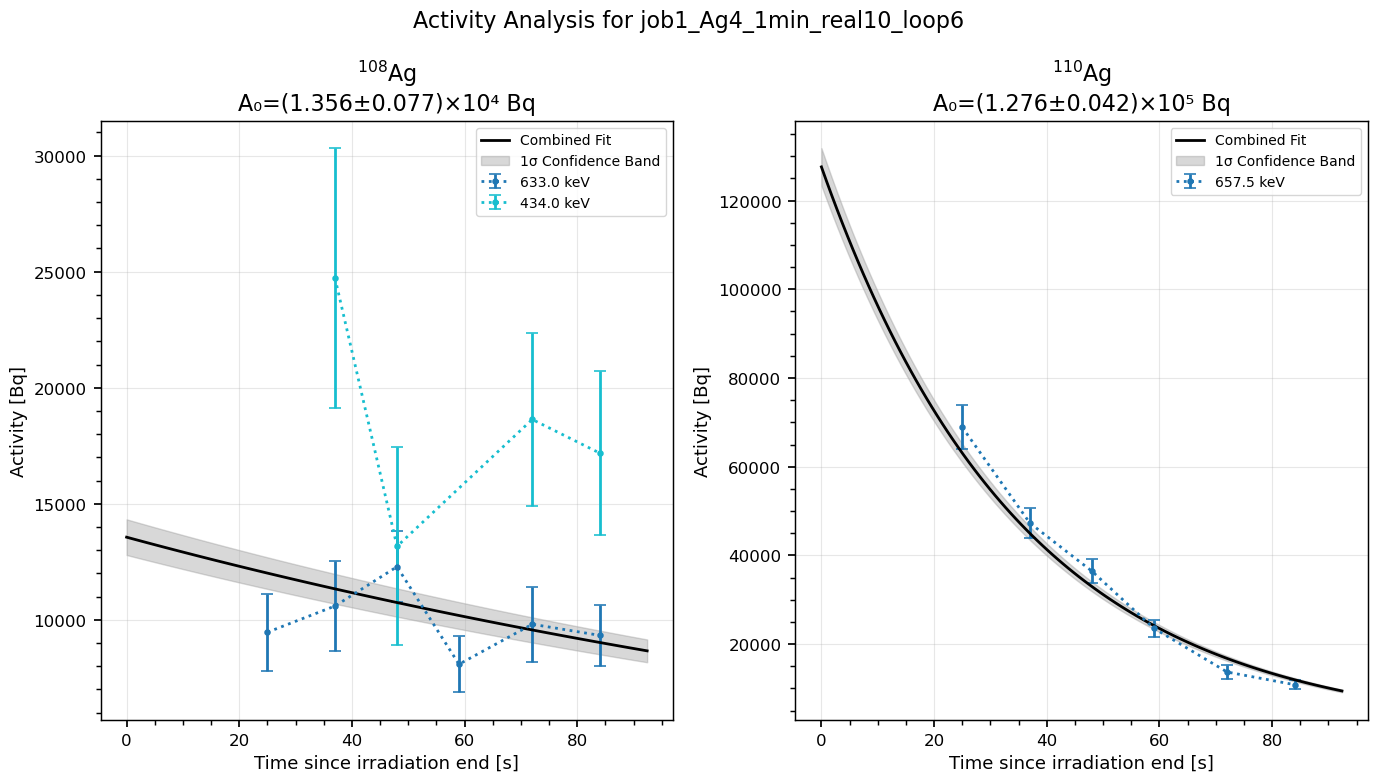

In [15]:
analysis_1.plot_activity()

### Job 2:
- Plate id: 10
- Irradiation time: 2 min
- Real time: 30s
- Num loops: 6

In [16]:
analysis_2 = SpectrumAnalysis(spec_exp_path / 'job2_Ag10_2min_real30_loop6', Δt_d=11)

Reading Spectrum /home/oskar/repos/summer_project/spectra/experiment/job2_Ag10_2min_real30_loop6_000.Spe
Reading Spectrum /home/oskar/repos/summer_project/spectra/experiment/job2_Ag10_2min_real30_loop6_001.Spe
Reading Spectrum /home/oskar/repos/summer_project/spectra/experiment/job2_Ag10_2min_real30_loop6_002.Spe
Reading Spectrum /home/oskar/repos/summer_project/spectra/experiment/job2_Ag10_2min_real30_loop6_003.Spe
Reading Spectrum /home/oskar/repos/summer_project/spectra/experiment/job2_Ag10_2min_real30_loop6_004.Spe
Reading Spectrum /home/oskar/repos/summer_project/spectra/experiment/job2_Ag10_2min_real30_loop6_005.Spe


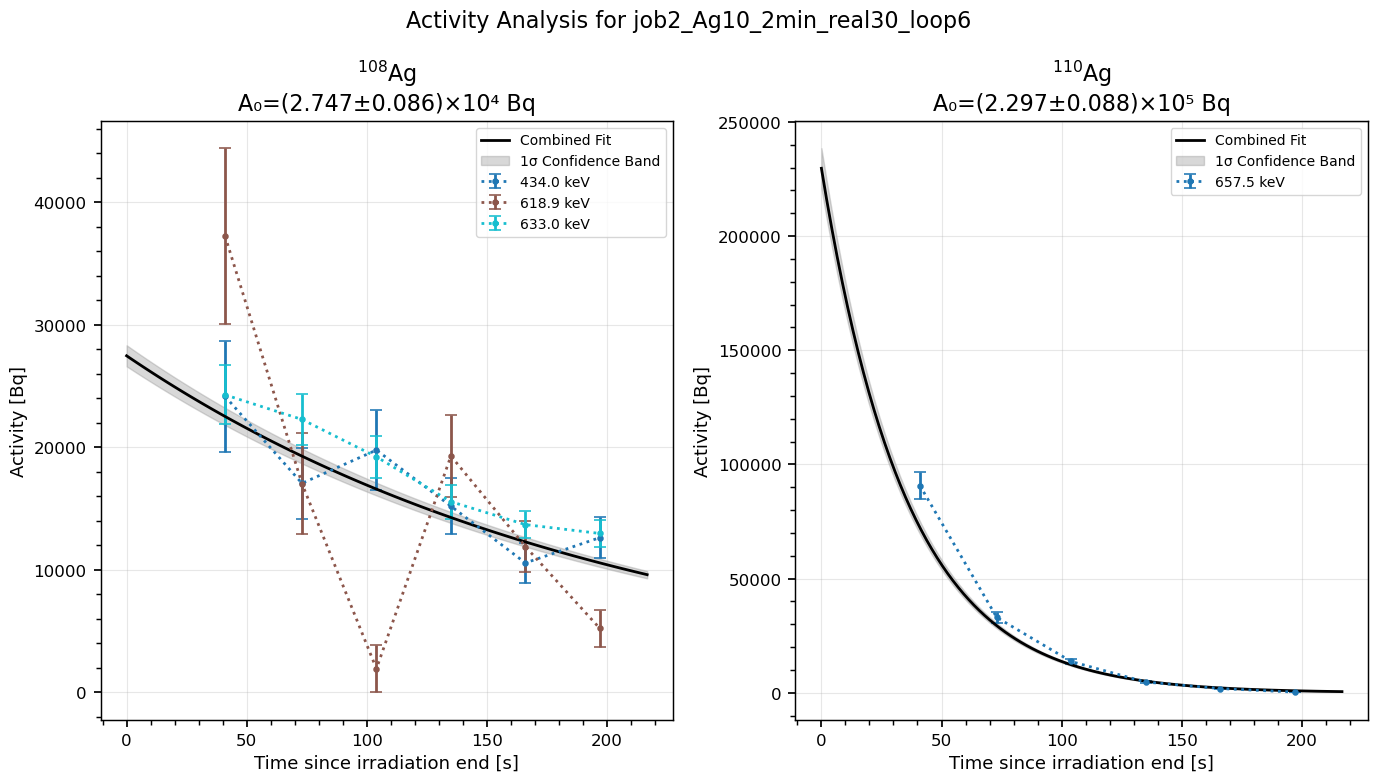

In [17]:
analysis_2.plot_activity()

### Job 3:
- Plate id: 73
- Irradiation time: 3 min
- Real time: 40s
- Num loops: 3

In [18]:
analysis_3 = SpectrumAnalysis(spec_exp_path / 'job3_Ag73_3min_real40_loop3', Δt_d=11)

Reading Spectrum /home/oskar/repos/summer_project/spectra/experiment/job3_Ag73_3min_real40_loop3_000.Spe
Reading Spectrum /home/oskar/repos/summer_project/spectra/experiment/job3_Ag73_3min_real40_loop3_001.Spe
Reading Spectrum /home/oskar/repos/summer_project/spectra/experiment/job3_Ag73_3min_real40_loop3_002.Spe


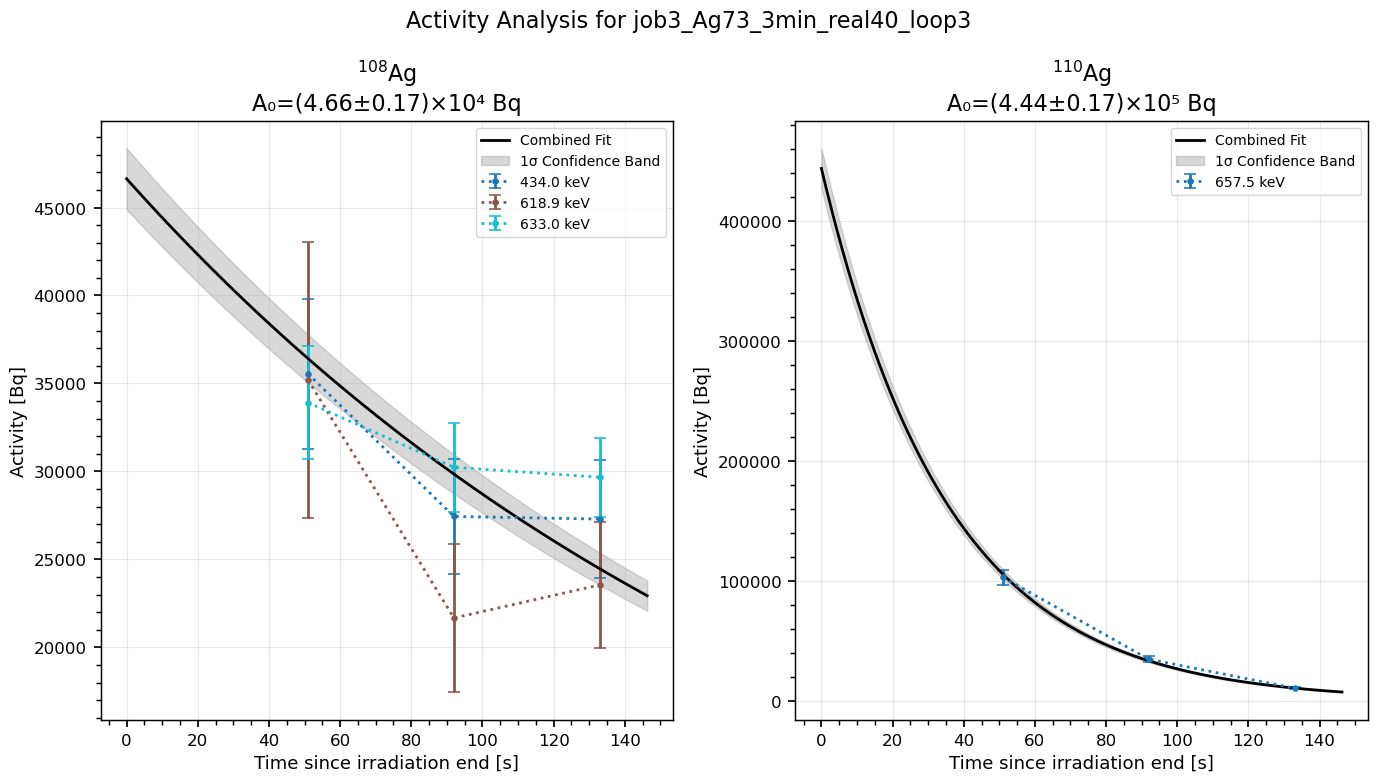

In [19]:
analysis_3.plot_activity()

### Job 4:
- Plate id: 2
- Irradiation time: 3 min
- Real time: 120s
- Num loops: 1

In [20]:
analysis_4 = SpectrumAnalysis(spec_exp_path / 'job4_Ag2_3min_real120_loop1', Δt_d=14)

Reading Spectrum /home/oskar/repos/summer_project/spectra/experiment/job4_Ag2_3min_real120_loop1_000.Spe


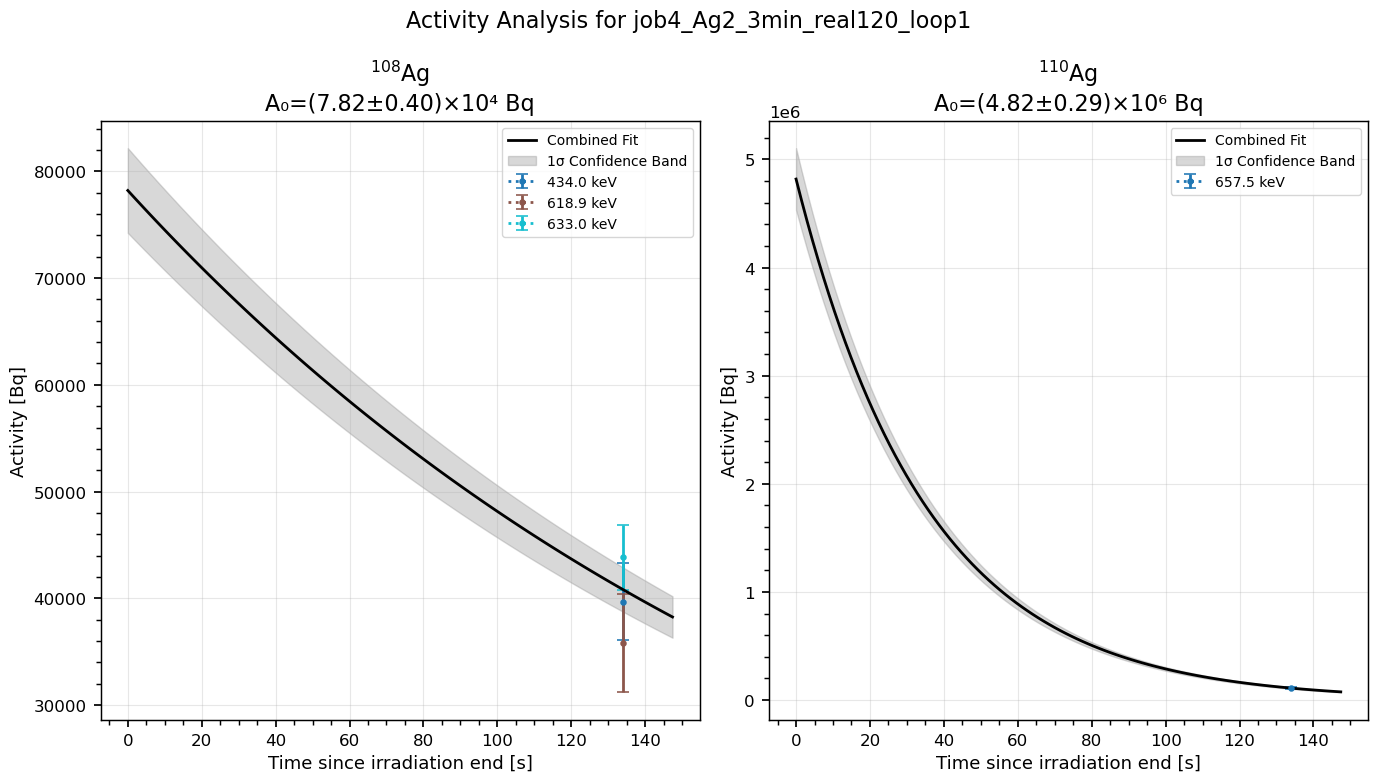

In [21]:
analysis_4.plot_activity()

### Job 5:
- Plate id: 4
- Irradiation time: 3 min
- Real time: 5s
- Num loops: 6

In [22]:
analysis_5 = SpectrumAnalysis(spec_exp_path / 'job5_Ag5_3min_real5_loop6', Δt_d=7)

Reading Spectrum /home/oskar/repos/summer_project/spectra/experiment/job5_Ag5_3min_real5_loop6_000.Spe
Reading Spectrum /home/oskar/repos/summer_project/spectra/experiment/job5_Ag5_3min_real5_loop6_001.Spe
Reading Spectrum /home/oskar/repos/summer_project/spectra/experiment/job5_Ag5_3min_real5_loop6_002.Spe
Reading Spectrum /home/oskar/repos/summer_project/spectra/experiment/job5_Ag5_3min_real5_loop6_003.Spe
Reading Spectrum /home/oskar/repos/summer_project/spectra/experiment/job5_Ag5_3min_real5_loop6_004.Spe
Reading Spectrum /home/oskar/repos/summer_project/spectra/experiment/job5_Ag5_3min_real5_loop6_005.Spe


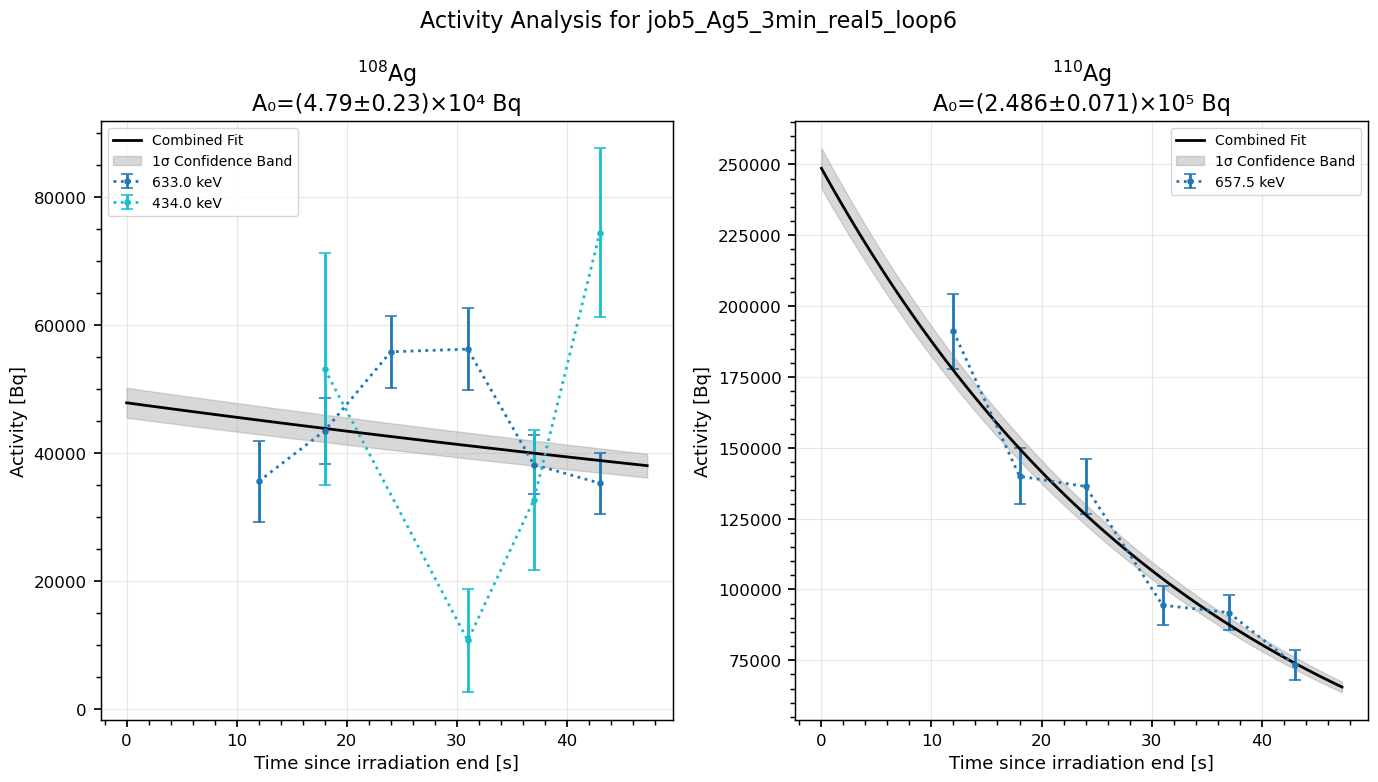

In [23]:
analysis_5.plot_activity()

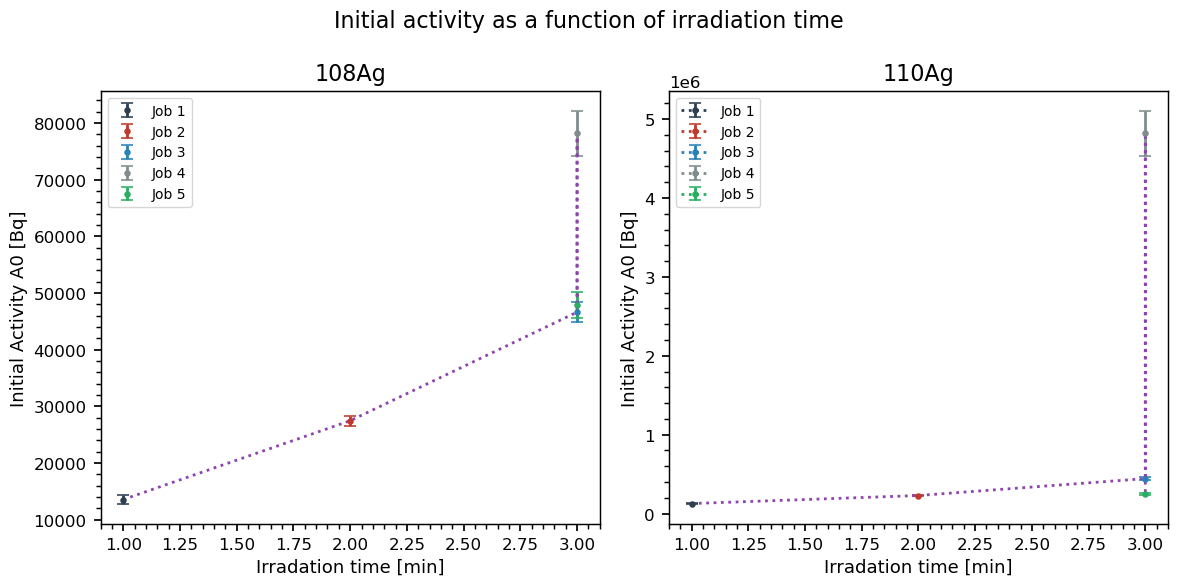

In [24]:
all_analyses = [analysis_1, analysis_2, analysis_3, analysis_4, analysis_5]
analysis_names = ['Job 1', 'Job 2', 'Job 3', 'Job 4', 'Job 5']
irradiation_times = [analysis.job_specs['irradiation_time'] for analysis in all_analyses]
A0_values_108 = [analysis.Ag108.A0.nominal_value for analysis in all_analyses]
A0_values_110 = [analysis.Ag110.A0.nominal_value for analysis in all_analyses]
A0_uncertainties_108 = [analysis.Ag108.A0.std_dev for analysis in all_analyses]
A0_uncertainties_110 = [analysis.Ag110.A0.std_dev for analysis in all_analyses] 

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
for i, analysis in enumerate(all_analyses):
    plt.errorbar(irradiation_times[i], A0_values_108[i], yerr=A0_uncertainties_108[i], fmt='o', label=analysis_names[i])
plt.plot(irradiation_times, A0_values_108, linestyle=':')

plt.xlabel('Irradation time [min]')
plt.ylabel('Initial Activity A0 [Bq]')
plt.title('108Ag')
plt.legend()

plt.subplot(1, 2, 2)
for i, analysis in enumerate(all_analyses):
    plt.errorbar(irradiation_times[i], A0_values_110[i], yerr=A0_uncertainties_110[i], marker='o', linestyle=':', label=analysis_names[i])   
plt.plot(irradiation_times, A0_values_110, linestyle=':')
    
plt.xlabel('Irradation time [min]')
plt.ylabel('Initial Activity A0 [Bq]')
plt.title('110Ag')
plt.legend()

plt.suptitle('Initial activity as a function of irradiation time')
plt.tight_layout()
plt.savefig(fig_path / 'initial_activity_vs_irradiation_time.pdf')
plt.show()